# Machine Learning Analysis on Building Data Genome Project


Dataset downloded from Kaggle: https://www.kaggle.com/claytonmiller/building-data-genome-project-v1

In [14]:
#import packages
import pandas as pd
import os
import matplotlib.pyplot as plt
import matplotlib

In [15]:
#import machine learning modules
import sklearn
from sklearn import metrics
from sklearn.neighbors import KNeighborsRegressor

from scipy.cluster.vq import kmeans, vq, whiten
from scipy.spatial.distance import cdist
import numpy as np
from datetime import datetime
import seaborn as sns

## Preprocessing Data For Regression

### Preprocessing weather data:

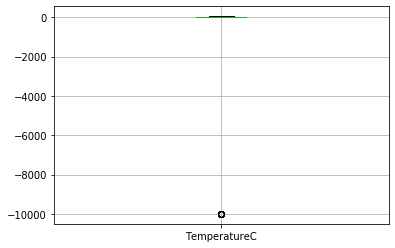

In [26]:
#loading the weather file and parse dates
df = pd.read_csv('weather0.csv', index_col = "timestamp", parse_dates = True)

# Extracting only the 'TemperatureC' column
df_temp =pd.read_csv('weather0.csv', index_col = "timestamp", parse_dates = True, usecols = ["TemperatureC", "timestamp"])
df_temp.head()
# Checking for outliers using boxplots
df_temp[['TemperatureC']].boxplot()


In [27]:
# Removing temperature outliers > -40 degrees
df_nooutlier = df_temp[df_temp > -40]
# Resampling the weather data hourly and Fill gaps 
df_hourly = df_nooutlier.resample("H").mean()
df_gapsfill = df_hourly.fillna(method='ffill')
df_gapsfill.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 8760 entries, 2015-01-01 00:00:00 to 2015-12-31 23:00:00
Freq: H
Data columns (total 1 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   TemperatureC  8760 non-null   float64
dtypes: float64(1)
memory usage: 136.9 KB


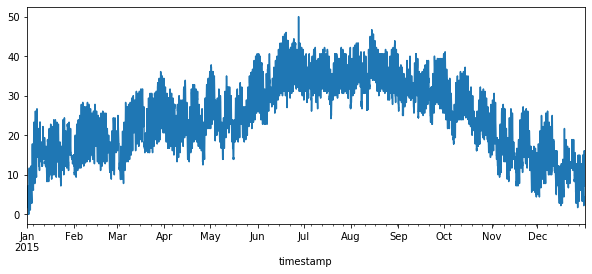

In [28]:
# Plotting the pre-processed data 
df_gapsfill["TemperatureC"].plot(figsize=(10,4))

In [29]:
# Extracting hour of the day and dayofweek for each data item -- adding them in a separate columns -- 

df_gapsfill['H'] = df_gapsfill.index.hour
df_gapsfill['D'] = df_gapsfill.index.dayofweek
df_gapsfill.head()



,TemperatureC,H,D
timestamp,,,
2015-01-01 00:00:00,2.8,0,3
2015-01-01 01:00:00,2.9,1,3
2015-01-01 02:00:00,2.8,2,3
2015-01-01 03:00:00,2.2,3,3
2015-01-01 04:00:00,2.2,4,3


In [30]:
# Featured Dataset for H and D Column
feature_dataset = pd.get_dummies(df_gapsfill,columns=['H','D'])
feature_dataset.head()


,TemperatureC,H_0,H_1,H_2,H_3,H_4,H_5,H_6,H_7,H_8,...,H_21,H_22,H_23,D_0,D_1,D_2,D_3,D_4,D_5,D_6
timestamp,,,,,,,,,,,,,,,,,,,,,
2015-01-01 00:00:00,2.8,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
2015-01-01 01:00:00,2.9,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
2015-01-01 02:00:00,2.8,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
2015-01-01 03:00:00,2.2,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
2015-01-01 04:00:00,2.2,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0


## Forecasting Energy Consumption
**Energy forecasting**

Energy forecasting is used for efficient operation and management of building energy as well as cost effective purchase of electricity amongst other applications. 


In [31]:
#Predicting with the Office Autumn.csv dataframe as target_dataset
td1 = pd.read_csv('Office_Autumn.csv', index_col = "timestamp", parse_dates = True)
#Resampling and fill gaps as done in the previous exercise.
td2 = td1.resample("H").mean()
target_dataset = td2.fillna(method='ffill')
target_dataset.head()


,Office_Autumn
timestamp,
2015-01-01 00:00:00,160.15
2015-01-01 01:00:00,162.95
2015-01-01 02:00:00,157.14
2015-01-01 03:00:00,266.57
2015-01-01 04:00:00,278.86


In [22]:
# Using months 4,5,6 in the training dataset and for test, using month 7. 
def runTheModel(feature_dataset, target_dataset, train_months=[4,5,6], test_month=[7]):
  """
  @Params:
    feature_dataset: is a pandas dataframe that contains all the features  
    target_dataset: is the metered_data dataframe. 
    train_months: (list) is a list of 3 sorted integers representing the training months.
    test_months: (list) is a list of integer representing the test month. 
  @Return:
    This function returns a dataframe of the prediction vs actual result .
  """

  
 
  x_train = feature_dataset[feature_dataset.index.month.isin(train_months)]

  y_train = target_dataset[target_dataset.index.month.isin(train_months)]


  x_test = feature_dataset[feature_dataset.index.month.isin(test_month)]

  y_test = target_dataset[target_dataset.index.month.isin(test_month)]
  
  # fit model
  model = KNeighborsRegressor().fit(np.array(x_train), np.array(y_train.values))
  tested_features = np.array(x_test)
    
  # using the model to make the prediction 
  predictions = model.predict(tested_features)
  predicted_vs_actual = pd.concat([y_test, pd.DataFrame(predictions, index=y_test.index)], axis=1)

  # creating a new dataframe that combines the actual data and the predicted data 
  predicted_vs_actual.columns = ["Actual", "Predicted"]
  #return predicted_vs_actual dataframe
  return predicted_vs_actual



In [23]:
runTheModel(feature_dataset=feature_dataset, target_dataset=target_dataset, train_months=[4,5,6], test_month=[7])

,Actual,Predicted
timestamp,,
2015-07-01 00:00:00,126.78,115.810
2015-07-01 01:00:00,112.28,201.500
2015-07-01 02:00:00,97.64,167.440
2015-07-01 03:00:00,120.08,149.190
2015-07-01 04:00:00,120.38,196.980
...,...,...
2015-07-31 19:00:00,148.55,166.946
2015-07-31 20:00:00,157.24,121.708
2015-07-31 21:00:00,131.95,139.480


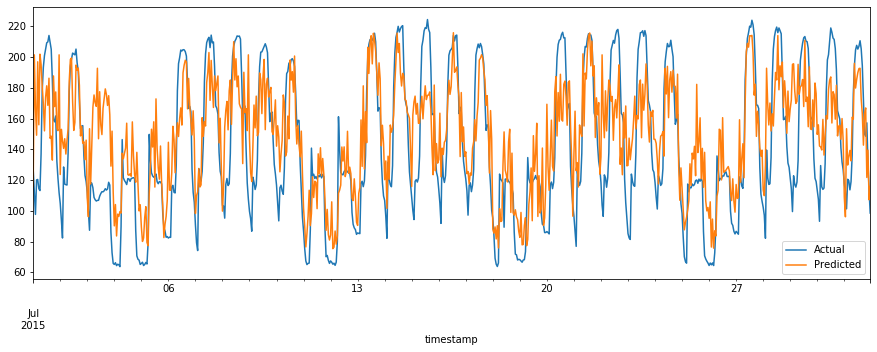

In [32]:
#Plotting Actual vs Predicted

x = runTheModel(feature_dataset=feature_dataset, target_dataset=target_dataset, train_months=[4,5,6], test_month=[7])
x.plot(figsize=(15,5))
